# Building Pipelines with Artifacts

Data science workflows revolve around building and refining pipelines, i.e. series of processes that transform data into useful information/product (read more about pipelines [here](https://docs.lineapy.org/en/latest/fundamentals/concepts.html#pipeline)).

Traditionally, this is often manual and time-consuming work as data scientists (or other engineers) need to clean up messy development code and transform it into deployable scripts for the target system (e.g., Airflow).

Having the complete development process stored in artifacts, LineaPy can automate such code transformation, accelerating transition from development to production. In this tutorial, we will walk through an example that illustrates how this can be done. 

**Table of Contents**

- Development
    - [Day 1: Exploration and Pre-processing](#Day-1:-Exploration-and-Pre-processing)
    - [Day 2: Modeling](#Day-2:-Modeling)
- Pipeline Building
    - [Input Parameters](#Input-Parameters)
    - [Output Files](#Output-Files)

<div class="alert alert-info">

You can ignore `# NBVAL_*` comments in certain cell blocks. They are for passing unit tests only, which we do to make sure the examples are always functional as we update the codebase.

</div>

In [1]:
import os
import lineapy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Development

### Day 1: Exploration and Pre-processing

As part of a public health study, we were given a data set to explore. Let's see what it contains.

In [2]:
# Load data
df = pd.read_csv("data/biometrics.csv")

In [3]:
# View data
df

,name,gender,height,weight
0,John,M,183,85
1,Mary,F,175,70
2,Nick,M,170,63
3,Stacy,F,162,50
4,Tom,M,168,75
5,Ava,F,185,72


It is simple data that has individuals' height and weight information. Our common sense dictates that these two physical traits may have an association. Let’s quickly check.

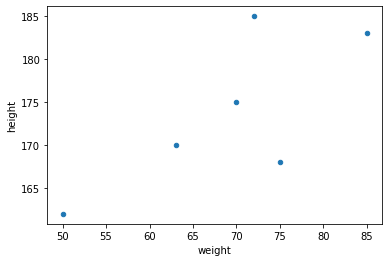

In [4]:
# Plot weight vs. height
df.plot.scatter("weight", "height")
plt.show()

The scatter plot suggests a linear relationship between weight and height.

What about gender? Does it have any role?

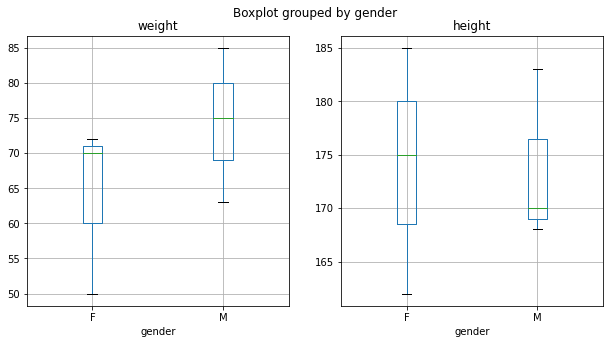

In [5]:
# Plot gender vs. weight
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df.boxplot("weight", "gender", ax=ax[0])
df.boxplot("height", "gender", ax=ax[1])
plt.show()

Gender seems to have some relevance to weight: we see males tend to be heavier than females.

Given these results, we might be interested in the relationship between height and weight *controlling for gender*. That is, given the same gender, how is change in height associated with change in weight?

Say we decided to use a linear model to examine this. Before doing any modeling, we need to pre-process the data. Specifically, `gender` needs to be transformed into a numeric variable so that the model can use it. Let’s code male as `0` and female as `1`.

In [6]:
# Create a numeric variable encoding gender
df["gender_numeric"] = df["gender"].map({"M": 0, "F": 1})

In [7]:
# View result
df

,name,gender,height,weight,gender_numeric
0,John,M,183,85,0
1,Mary,F,175,70,1
2,Nick,M,170,63,0
3,Stacy,F,162,50,1
4,Tom,M,168,75,0
5,Ava,F,185,72,1


Let's export the pre-processed data so that it can be used for other explorations.

In [8]:
# Export pre-processed data as a CSV file
df.to_csv("output/biometrics_preprocessed.csv", index=False)

Let's also save the session as a LineaPy artifact to store the development history.

In [9]:
# NBVAL_IGNORE_OUTPUT

# Save side effects as an artifact
lineapy.save(lineapy.file_system, "biometrics_preprocessed")

LineaArtifact(name='biometrics_preprocessed', version='2022-04-15T01:29:54')

It's already quite late, so let's call it a day and we will work on modeling tomorrow.

### Day 2: Modeling

It is a new day and we start working on model building &mdash; in a separate script/notebook. Let's load the pre-processed data from the day before.

In [10]:
# Load pre-processed data
df_processed = pd.read_csv("output/biometrics_preprocessed.csv")

In [11]:
# View data
df_processed

,name,gender,height,weight,gender_numeric
0,John,M,183,85,0
1,Mary,F,175,70,1
2,Nick,M,170,63,0
3,Stacy,F,162,50,1
4,Tom,M,168,75,0
5,Ava,F,185,72,1


In [12]:
# Initiate the model
lm = LinearRegression()

In [13]:
# Fit the model
lm.fit(
    X=df_processed[["height", "gender_numeric"]],
    y=df_processed["weight"],
)

LinearRegression()

In [14]:
# NBVAL_IGNORE_OUTPUT

# Check result
print(f"Coefficient for height: {lm.coef_[0]}")
print(f"Coefficient for gender: {lm.coef_[1]}")

Coefficient for height: 1.0016722408026753
Coefficient for gender: -10.667224080267554


Result suggests that, controlling for gender, a unit increase in height is associated with about a unit increase in weight. Interestingly, we also see the gender difference in weight quantified: controlling for height, females tend to be about 10 units lighter than males.

Now, we save the model so we can discuss it with other colleagues later this week.

In [15]:
# NBVAL_IGNORE_OUTPUT

# Save the fitted model as an artifact
lineapy.save(lm, "linear_model")

LineaArtifact(name='linear_model', version='2022-04-15T01:29:54')

## Pipeline Building

We shared our model results with the rest of the team and got the feedback that the gender coefficient might be an interesting feature to use for the other project on modeling gender differences. So, we got asked to make this variable readily available as well as updated on a regular basis to account for the new data. Now, we need to set up a pipeline to calculate the gender coefficient.

We first save the variable of interest as an artifact to store its development history or *lineage*.

In [16]:
# Retrieve model artifact
mod_artifact = lineapy.get("linear_model")

In [17]:
# Get model itself
mod = mod_artifact.get_value()

In [18]:
# NBVAL_IGNORE_OUTPUT

# Save gender coefficient as an artifact
gender_coef = mod.coef_[1]
lineapy.save(gender_coef, "gender_diff_weight")

LineaArtifact(name='gender_diff_weight', version='2022-04-15T01:29:55')

Now that we have the complete development history stored in artifacts, we are ready to use them to quickly build a pipeline. Our pipeline consists of three processing “nodes”:

1. Data pre-processing that produces a transformed CSV
2. Model fitting based on the transformed CSV
3. Extraction of the desired coefficient from the model

And we load artifacts corresponding to these nodes:

In [19]:
# Load artifacts to use in pipeline building
preprocessing_art = lineapy.get("biometrics_preprocessed")
modeling_art = lineapy.get("linear_model")
extraction_art = lineapy.get("gender_diff_weight")

### Input Parameters

We now “stitch” these artifacts to form a pipeline, like so:

In [20]:
# NBVAL_IGNORE_OUTPUT

# Build an Airflow pipeline using artifacts
lineapy.to_pipeline(
    artifacts=[
        extraction_art.name,
        modeling_art.name,
        preprocessing_art.name,
    ],
    pipeline_name="demo_airflow_pipeline",
    dependencies={
        extraction_art.name: { modeling_art.name },
        modeling_art.name: { preprocessing_art.name},
    },
    output_dir="output/03_build_pipelines/demo_airflow_pipeline/",
    framework="AIRFLOW",
)

Pipeline source generated in the directory: output/03_build_pipelines/demo_airflow_pipeline

Generated python module demo_airflow_pipeline.py

Added Airflow DAG named demo_airflow_pipeline_dag. Start a run from the Airflow UI or CLI.

Generated Dockerfile demo_airflow_pipeline_Dockerfile

Generated requirements file demo_airflow_pipeline_requirements.txt

PosixPath('output/03_build_pipelines/demo_airflow_pipeline')

where

- `artifacts` is the list of artifact names to be used for the pipeline
- `pipeline_name` is the name of the pipeline
- `dependencies` is the dependency graph among artifacts
    - If artifact A depends on artifacts B and C, then the graph is specified as `{ A: { B, C } }`
    - If A depends on B and B depends on C, then the graph is specified as `{ A: { B }, B: { C } }`
- `output_dir` is the location to put the files for running the pipeline
- `framework` is the name of orchestration framework to use
    - LineaPy currently supports `"AIRFLOW"` and `"SCRIPT"`
    - If `"AIRFLOW"`, it will generate files that can run Airflow DAGs
    - If `"SCRIPT"`, it will generate files that can run the pipeline as a Python script

### Output Files

We see the pipeline building resulting in the following files:

In [21]:
# NBVAL_IGNORE_OUTPUT

# Check the generated files for running the pipeline
os.listdir("output/03_build_pipelines/demo_airflow_pipeline/")

['demo_airflow_pipeline.py',
 'demo_airflow_pipeline_dag.py',
 'demo_airflow_pipeline_Dockerfile',
 'demo_airflow_pipeline_requirements.txt']

where

- `[PIPELINE-NAME].py` contains the artifact code packaged as a function module
- `[PIPELINE-NAME]_dag.py` uses the packaged function(s) to define the pipeline
- `[PIPELINE-NAME]_requirements.txt` lists any package dependencies for running the pipeline
- `[PIPELINE-NAME]_Dockerfile` contains commands to set up the environment to run the pipeline

Specifically, in the current case, we have `demo_airflow_pipeline.py` looking as follows:

```python
# %load output/03_build_pipelines/demo_airflow_pipeline/demo_airflow_pipeline.py
import lineapy
import pandas as pd
from sklearn.linear_model import LinearRegression


def gender_diff_weight():
    mod_artifact = lineapy.get("linear_model")
    mod = mod_artifact.get_value()
    gender_coef = mod.coef_[1]


def linear_model():
    df = pd.read_csv("data/biometrics.csv")
    df["gender_numeric"] = df["gender"].map({"M": 0, "F": 1})
    df.to_csv("output/biometrics_preprocessed.csv", index=False)
    df_processed = pd.read_csv("output/biometrics_preprocessed.csv")
    lm = LinearRegression()
    lm.fit(
        X=df_processed[["height", "gender_numeric"]],
        y=df_processed["weight"],
    )


def biometrics_preprocessed():
    df = pd.read_csv("data/biometrics.csv")
    df["gender_numeric"] = df["gender"].map({"M": 0, "F": 1})
    df.to_csv("output/biometrics_preprocessed.csv", index=False)
```

We can see that LineaPy used artifacts to automatically 1) slice their code to retain only essential operations and 2) package the sliced code into importable functions.

And we see `demo_airflow_pipeline_dag.py` automatically composing an Airflow DAG with these functions:

```python
# %load output/03_build_pipelines/demo_airflow_pipeline/demo_airflow_pipeline_dag.py
import os

import demo_airflow_pipeline
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from airflow.utils.dates import days_ago

default_dag_args = {"owner": "airflow", "retries": 2, "start_date": days_ago(1)}

dag = DAG(
    dag_id="demo_airflow_pipeline_dag",
    schedule_interval="*/15 * * * *",
    max_active_runs=1,
    catchup=False,
    default_args=default_dag_args,
)


gender_diff_weight = PythonOperator(
    dag=dag,
    task_id="gender_diff_weight_task",
    python_callable=demo_airflow_pipeline.gender_diff_weight,
)

linear_model = PythonOperator(
    dag=dag,
    task_id="linear_model_task",
    python_callable=demo_airflow_pipeline.linear_model,
)

biometrics_preprocessed = PythonOperator(
    dag=dag,
    task_id="biometrics_preprocessed_task",
    python_callable=demo_airflow_pipeline.biometrics_preprocessed,
)


linear_model >> gender_diff_weight
biometrics_preprocessed >> linear_model
```

Also noteworthy is the automatically generated Dockerfile, which further facilitates our transition to production:

```dockerfile
# %load output/03_build_pipelines/demo_airflow_pipeline/demo_airflow_pipeline_Dockerfile
FROM apache/airflow:latest

RUN mkdir /tmp/installers
WORKDIR /tmp/installers

# copy all the requirements to run the current dag
COPY ./demo_airflow_pipeline_requirements.txt ./
# install the required libs
RUN pip install -r ./demo_airflow_pipeline_requirements.txt

WORKDIR /opt/airflow/dags
COPY . .

WORKDIR /opt/airflow

CMD [ "standalone" ]
```

These files, once placed in the location that Airflow expects (usually `dag/` under Airflow’s home directory), should let us immediately execute the pipeline from the UI or CLI.